In [1]:
#inspired by https://github.com/subramanya1997/cryptocurrency-price-prediction
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM, SimpleRNN
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error

import glob
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [2]:
path = r'data/'                     # use your path
all_files = glob.glob(os.path.join(path, "DOT.csv"))
data = pd.read_csv(all_files[0])
data = data.set_index('datetime')

In [3]:
data

,o,h,l,c,v
datetime,,,,,
2020-08-18 02:00:00,2.0900,4.4400,2.0000,3.1000,6039881.97
2020-08-19 02:00:00,3.1000,3.1999,2.6400,2.9500,15895774.92
2020-08-20 02:00:00,2.9449,3.1111,2.6000,2.9000,11040863.60
2020-08-21 02:00:00,2.8978,3.0900,2.6826,2.8330,9765153.74
2020-08-22 02:00:00,2.8387,4.5500,2.7820,4.4546,41611476.51
...,...,...,...,...,...
2021-11-26 01:00:00,39.4800,39.6200,33.6700,34.5600,16596267.73
2021-11-27 01:00:00,34.5500,36.1200,34.4300,35.1600,6817533.23
2021-11-28 01:00:00,35.1600,35.8500,32.2100,35.7600,10439305.23


In [4]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

def unscale(arr,scaler):
    arr = arr.reshape(-1, 1)
    arr = np.concatenate((arr,arr,arr,arr,arr),axis=1)
    arr = scaler.inverse_transform(arr)
    arr = arr[:][:,0] 
    return arr

def plot_cov_matrix(dataset):
    covMatrix = np.cov(np.rot90(dataset),bias=True)
    print(covMatrix.shape)
    plt.rcParams["figure.figsize"] = [7.00, 3.50]
    plt.rcParams["figure.autolayout"] = True
    im = plt.imshow(covMatrix, cmap="gray")
    plt.colorbar(im)
    plt.show()

(5, 5)


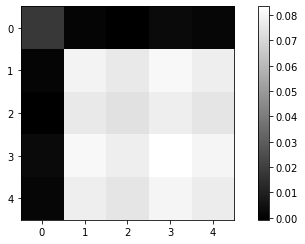

In [5]:
scaler = MinMaxScaler()
data[['l', 'o', 'h', 'c', 'v']]= scaler.fit_transform(data[['l', 'o', 'h', 'c', 'v']])
plot_cov_matrix(data)

In [6]:
pca = PCA(n_components=3)
data_pca = data
data_pca = pca.fit_transform(data_pca)
data_pca = pd.DataFrame(data_pca, columns=['pc1', 'pc2', 'pc3'])

In [7]:
train, test = train_test_split(data, test_size=0.2)

In [8]:
test

,o,h,l,c,v
datetime,,,,,
2021-08-29 02:00:00,0.461345,0.449423,0.463317,0.448487,0.053741
2021-08-30 02:00:00,0.456513,0.470962,0.444976,0.454959,0.166749
2021-08-31 02:00:00,0.463085,0.555000,0.470694,0.559299,0.493679
2021-09-01 02:00:00,0.565327,0.591308,0.550239,0.595191,0.308417
2021-09-02 02:00:00,0.600696,0.579038,0.582935,0.567929,0.149248
...,...,...,...,...,...
2021-11-26 01:00:00,0.722652,0.702500,0.631380,0.622257,0.188737
2021-11-27 01:00:00,0.627368,0.635192,0.646531,0.634024,0.064518
2021-11-28 01:00:00,0.639157,0.630000,0.602273,0.645792,0.110525


In [9]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

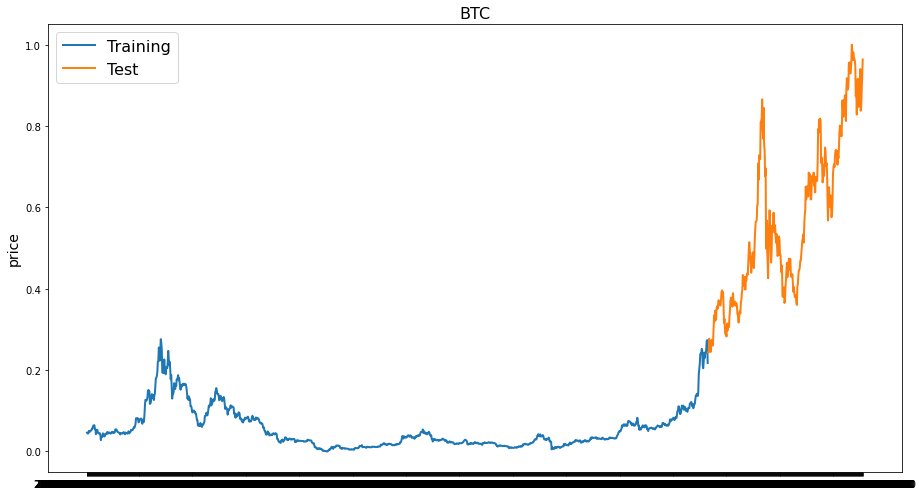

In [114]:
line_plot(train['c'], test['c'], 'Training', 'Test', title='BTC')

In [10]:
def extract_window_data(df, window_len=5):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()

        window_data.append(tmp.values)
    return np.array(window_data)

In [11]:
def prepare_data(df_X, df_y, target_col, window_len=10, test_size=0.2):
    train_data, test_data = train_test_split(df_X, test_size=test_size)
    train_data_y, test_data_y = train_test_split(df_y, test_size=test_size)
    
    X_train = extract_window_data(train_data, window_len)
    X_test = extract_window_data(test_data, window_len)
    y_train = train_data_y[target_col][window_len:].values
    y_test = test_data_y[target_col][window_len:].values

    return train_data, test_data, X_train, X_test, y_train, y_test

In [12]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [13]:
def build_rnn_hidden_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'): 
    model = Sequential()
    model.add(SimpleRNN(neurons, input_shape=(input_data.shape[1],input_data.shape[2])))

    # add an output layer to make final predictions 
    model.add(Dense(150, activation='relu'))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
np.random.seed(42)
window_len = 7
test_size = 0.2
lstm_neurons = 100
epochs = 50
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [15]:
a, b, X_train, X_test, y_train, y_test = prepare_data(data_pca, data, 'c', window_len=window_len, test_size=test_size)

In [16]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(369, 7, 3)
(87, 7, 3)
(369,)
(87,)


In [17]:
callback = EarlyStopping(monitor='val_loss', patience=10)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True, validation_split=0.2, callbacks=[callback])

Epoch 1/50
10/10 [==============================] - 3s 67ms/step - loss: 0.1084 - val_loss: 0.0544
Epoch 2/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0259 - val_loss: 0.0020
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0113 - val_loss: 0.0023
Epoch 4/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0074 - val_loss: 0.0058
Epoch 5/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 6/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 7/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0020
Epoch 8/50
10/10 [==============================] - 0s 12ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 9/50
10/10 [==============================] - 0s 13ms/step - loss: 0.0048 - val_loss: 0.0017
Epoch 10/50
10/10 [==============================] - 0s 14ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 11/

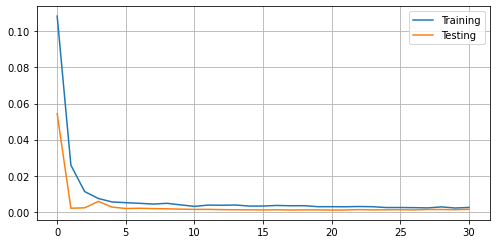

In [18]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Testing')
plt.legend()
plt.grid()
plt.show()

In [19]:
targets = test['c'][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.039445279643033015

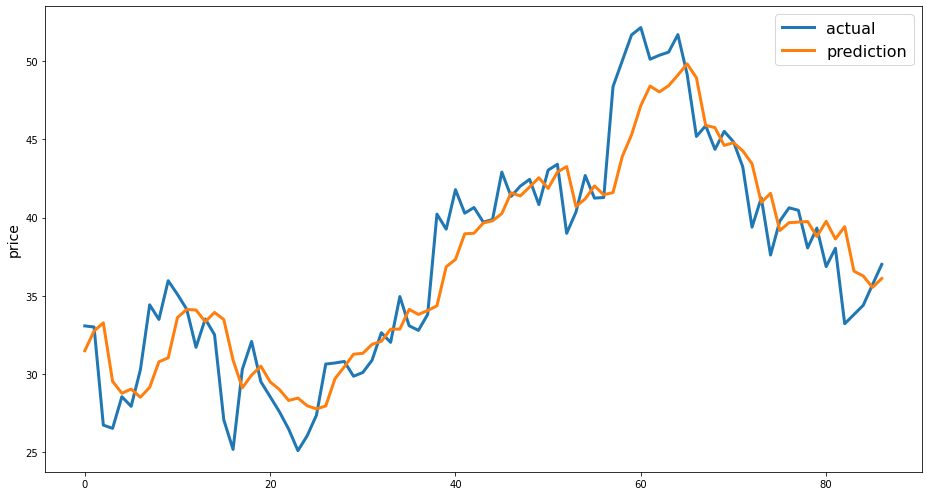

In [20]:
preds_unsc = unscale(preds,scaler)
targets_unsc = unscale(targets.values,scaler)
preds = pd.Series(index=targets.index, data=preds_unsc)
line_plot(targets_unsc, preds_unsc, 'actual', 'prediction', lw=3)

In [43]:
def predict_tomorrow(file_name, verbose=0):
    data = pd.read_csv(all_files)
    data = data.set_index('datetime')
    
    scaler = MinMaxScaler()
    data[['l', 'o', 'h', 'c', 'v']]= scaler.fit_transform(data[['l', 'o', 'h', 'c', 'v']])

    pca = PCA(n_components=3)
    data_pca = data
    data_pca = pca.fit_transform(data)
    data_pca = pd.DataFrame(data_pca, columns=['pc1', 'pc2', 'pc3'])
    
    np.random.seed(42)
    window_len = 7
    test_size = 0.2
    lstm_neurons = 100
    epochs = 50
    batch_size = 32
    loss = 'mse'
    dropout = 0.2
    optimizer = 'adam'
    
    a, b, X_train, X_test, y_train, y_test = prepare_data(data_pca, data, 'c', window_len=window_len, test_size=test_size)
    
    callback = EarlyStopping(monitor='val_loss', patience=10)
    model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, shuffle=True, validation_split=0.2, callbacks=[callback])
    
    temp = data_pca[-window_len:].values
    
    test_pred = []

    test_pred.append(temp)
    test_pred = np.stack(test_pred)
    
    
    print("validation loss :", history.history['val_loss'][-1])
    
    preds = model.predict(test_pred)
    
    tommorow_pred = preds[-1]
    
    tommorow_price = unscale(tommorow_pred, scaler)

    return tommorow_price

In [49]:
path = r'data/'                     # use your path
file = glob.glob(os.path.join(path, "DOT.csv"))[0]
name = file.split('/', 1 )
name = name[1].split('.', 1 )[0]

price = predict_tomorrow(file, verbose=0)

print("tomorrow price for ",name, " is: ",price[0])

(7, 3)
validation loss : 0.0027337067294865847
tomorrow price for  DOT  is:  37.205315
